In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, accuracy_score,confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define the model
class MultiClassLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiClassLogisticRegression, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.fc(x)

In [4]:
import pandas as pd

# Load training and testing data
train_csv_path = "train_labels_cleaned.csv"
test_csv_path = "test_labels_cleaned.csv"
valid_csv_path = "validate_labels_cleaned.csv"

train_data = pd.read_csv(train_csv_path)
valid_data = pd.read_csv(valid_csv_path)
test_data = pd.read_csv(test_csv_path)

# Ensure both CSVs have 'filepath' and 'label' columns
train_file_paths = train_data['image_path'].values
train_labels = train_data['class'].values

test_file_paths = test_data['image_path'].values
test_labels = test_data['class'].values

valid_file_paths = valid_data['image_path'].values
valid_labels = valid_data['class'].values

In [5]:
class_labels = np.unique(train_labels)
label_encoder = LabelEncoder()

In [6]:
# Hyperparameters
input_dim = 2048  # Number of features
output_dim = 11  # Number of classes
learning_rate = 0.01
epochs = 10

X_train = np.load("./resnet100_train_features.npy")
y_train = label_encoder.fit_transform(train_labels)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Prepare DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [7]:
X_val = np.load("./resnet100_val_features.npy")
y_val = label_encoder.fit_transform(valid_labels)

# Convert numpy arrays to PyTorch tensors
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
val_dataset = TensorDataset(X_val, y_val)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [8]:
X_test = np.load("./resnet100_test_features.npy")
y_test = label_encoder.fit_transform(test_labels)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Prepare DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [9]:
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'labels' is a list of label names
# Example: labels = ['Class 0', 'Class 1', ..., 'Class n']

# Binarize the true labels (for ROC)

def save_roc_curve(y_true, y_prob, class_labels, path):

    num_classes = 11
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # num_classes should be set to the number of classes in your dataset

    # Compute ROC curve and ROC AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc='lower right')
    # plt.show()
    plt.savefig(path)


In [10]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          path=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    Percent:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html            
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        # The original percent calculation is here, but its no good
        # group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        # Fixed below
        cm_norm = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]
        group_percentages = cm_norm.flatten()
        group_percentages = np.around(group_percentages, 2)
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # Fix to color by percentages
    if percent:
        cf = cm_norm
        
    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    plt.savefig(path)

In [ ]:
%%time

import os
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
import itertools


def save_confusion_matrix(y_true, y_pred, save_path):
    cfm = confusion_matrix(y_true, y_pred)
    make_confusion_matrix(cfm, percent = True, count= True, categories=class_labels, figsize = (10,10), path=save_path)

# Define hyperparameter search space
learning_rates = [0.1, 0.01, 0.001, 0.0001]
# learning_rates = [0.1]
batch_sizes = [64]
weight_decays = [0, 1e-4, 1e-3]
epochs = 125

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(learning_rates, batch_sizes, weight_decays))

# Define base folder to save results
results_base_folder = "./results/"
os.makedirs(results_base_folder, exist_ok=True)
results_dict = {}

# Training loop
for lr, batch_size, weight_decay in hyperparameter_combinations:
    # Create a subfolder for this hyperparameter combination
    combination_folder = os.path.join(results_base_folder, f"lr_{lr}_bs_{batch_size}_wd_{weight_decay}")
    os.makedirs(combination_folder, exist_ok=True)
    
    print(f"Testing with learning_rate={lr}, batch_size={batch_size}, weight_decay={weight_decay}")
    
    # Adjust DataLoader with the current batch_size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Add test loader
    
    # Instantiate the model, loss function, and optimizer
    model = MultiClassLogisticRegression(input_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_val_loss = float('inf')  # Initialize to a large number
    best_model_path = os.path.join(combination_folder, 'best_model.pth')  # Path to save the best model
    
    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
    
        # Validation phase
        model.eval()
        y_val_true, y_val_pred = [], []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_val_true.extend(labels.cpu().numpy())
                y_val_pred.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)  # Save the best model
            print(f"Epoch {epoch+1}: Best model saved with validation loss = {val_loss:.4f}")

    # Reload the best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # Evaluation metrics on train, val, and test sets
    def evaluate(loader):
        y_true, y_pred = [], []
        total_loss = 0.0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        total_loss /= len(loader)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return total_loss, accuracy, precision, recall, f1

    train_loss, train_accuracy, train_precision, train_recall, train_f1 = evaluate(train_loader)
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(val_loader)
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader)

    # Save results for the best model
    results = {
        "learning_rate": lr,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "train_metrics": {
            "loss": train_loss,
            "accuracy": train_accuracy,
            "precision": train_precision,
            "recall": train_recall,
            "f1": train_f1,
        },
        "val_metrics": {
            "loss": val_loss,
            "accuracy": val_accuracy,
            "precision": val_precision,
            "recall": val_recall,
            "f1": val_f1,
        },
        "test_metrics": {
            "loss": test_loss,
            "accuracy": test_accuracy,
            "precision": test_precision,
            "recall": test_recall,
            "f1": test_f1,
        }
    }
    results_dict[combination_folder] = results
    # Save metrics to a JSON file
    metrics_path = os.path.join(combination_folder, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(results, f, indent=4)

    print(f"Results for the best model saved to {combination_folder}")


Testing with learning_rate=0.1, batch_size=64, weight_decay=0


  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:02<05:04,  2.45s/it]

Epoch 1: Best model saved with validation loss = 1.4712


  4%|▍         | 5/125 [00:12<04:52,  2.43s/it]

Epoch 5: Best model saved with validation loss = 1.2530


  9%|▉         | 11/125 [00:26<04:34,  2.41s/it]

Epoch 11: Best model saved with validation loss = 1.2512


 20%|██        | 25/125 [01:00<04:04,  2.44s/it]

Epoch 25: Best model saved with validation loss = 1.1856


 26%|██▌       | 32/125 [01:17<03:45,  2.43s/it]

Epoch 32: Best model saved with validation loss = 1.0991


 32%|███▏      | 40/125 [01:37<03:26,  2.43s/it]

Epoch 40: Best model saved with validation loss = 1.0820


100%|██████████| 125/125 [05:03<00:00,  2.43s/it]


Results for the best model saved to ./results/lr_0.1_bs_64_wd_0
Testing with learning_rate=0.1, batch_size=64, weight_decay=0.0001


  1%|          | 1/125 [00:02<05:05,  2.47s/it]

Epoch 1: Best model saved with validation loss = 2.3866


  2%|▏         | 2/125 [00:05<05:08,  2.51s/it]

Epoch 2: Best model saved with validation loss = 2.3179


  2%|▏         | 3/125 [00:07<05:02,  2.48s/it]

Epoch 3: Best model saved with validation loss = 1.2590


 10%|█         | 13/125 [00:32<04:36,  2.47s/it]

Epoch 13: Best model saved with validation loss = 1.2081


 13%|█▎        | 16/125 [00:39<04:30,  2.48s/it]

Epoch 16: Best model saved with validation loss = 1.1635


 17%|█▋        | 21/125 [00:52<04:19,  2.50s/it]

Epoch 21: Best model saved with validation loss = 1.1317


 26%|██▌       | 32/125 [01:19<03:49,  2.47s/it]

Epoch 32: Best model saved with validation loss = 1.0892


 30%|██▉       | 37/125 [01:31<03:37,  2.48s/it]

Epoch 37: Best model saved with validation loss = 1.0814


 30%|███       | 38/125 [01:34<03:35,  2.48s/it]

Epoch 38: Best model saved with validation loss = 1.0493


 91%|█████████ | 114/125 [04:43<00:27,  2.47s/it]

Epoch 114: Best model saved with validation loss = 1.0399


100%|██████████| 125/125 [05:10<00:00,  2.49s/it]


Results for the best model saved to ./results/lr_0.1_bs_64_wd_0.0001
Testing with learning_rate=0.1, batch_size=64, weight_decay=0.001


  1%|          | 1/125 [00:02<05:08,  2.49s/it]

Epoch 1: Best model saved with validation loss = 1.9408


  2%|▏         | 2/125 [00:05<05:08,  2.51s/it]

Epoch 2: Best model saved with validation loss = 1.7808


  2%|▏         | 3/125 [00:07<05:03,  2.49s/it]

Epoch 3: Best model saved with validation loss = 1.6688


  3%|▎         | 4/125 [00:09<04:58,  2.47s/it]

Epoch 4: Best model saved with validation loss = 1.3615


  5%|▍         | 6/125 [00:14<04:56,  2.49s/it]

Epoch 6: Best model saved with validation loss = 1.2863


 13%|█▎        | 16/125 [00:40<04:33,  2.51s/it]

Epoch 16: Best model saved with validation loss = 1.2246


 18%|█▊        | 23/125 [00:57<04:11,  2.47s/it]

Epoch 23: Best model saved with validation loss = 1.1665


 50%|█████     | 63/125 [02:37<02:38,  2.56s/it]

Epoch 63: Best model saved with validation loss = 1.0939


100%|██████████| 125/125 [05:10<00:00,  2.49s/it]


Results for the best model saved to ./results/lr_0.1_bs_64_wd_0.001
CPU times: user 15min 34s, sys: 22.5 s, total: 15min 57s
Wall time: 15min 33s


In [11]:

# Model evaluation (use a validation set or test set)
state_dict = torch.load("/home/jspetrisko/cv/lgr_results/lr_0.1_bs_64_wd_0/best_model.pth")

model = MultiClassLogisticRegression(input_dim, output_dim).to(device)

# 3. Load the state dictionary into your model
model.load_state_dict(state_dict)

# 4. Set the model to evaluation mode (if needed)
model.eval() 

# model.eval()  # Set the model to evaluation mode
X_test = np.load("./resnet100_test_features.npy")
y_test = label_encoder.fit_transform(test_labels)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Prepare DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
print(X_test.shape)
y_true = []
y_pred = []
y_prob = []
with torch.no_grad():  # No gradients needed during inference
    for inputs, labels in tqdm(test_loader):  # Assuming you have a test DataLoader
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
        
        outputs = model(inputs)  # Get the model's outputs
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        y_prob.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())  # Store the true labels on the CPU
        y_pred.extend(predicted.cpu().numpy())  # Store the predicted labels on the CPU

torch.Size([30000, 2048])


100%|██████████| 469/469 [00:00<00:00, 513.71it/s]


In [12]:
# Convert the lists to numpy arrays for metric calculation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' to handle imbalanced classes
recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' to handle imbalanced classes

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7044
Precision: 0.7254
Recall: 0.7044


In [13]:
precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

(0.7254431706376238, 0.7043666666666667, 0.6933124642717443, None)

AttributeError: 'NoneType' object has no attribute 'write'

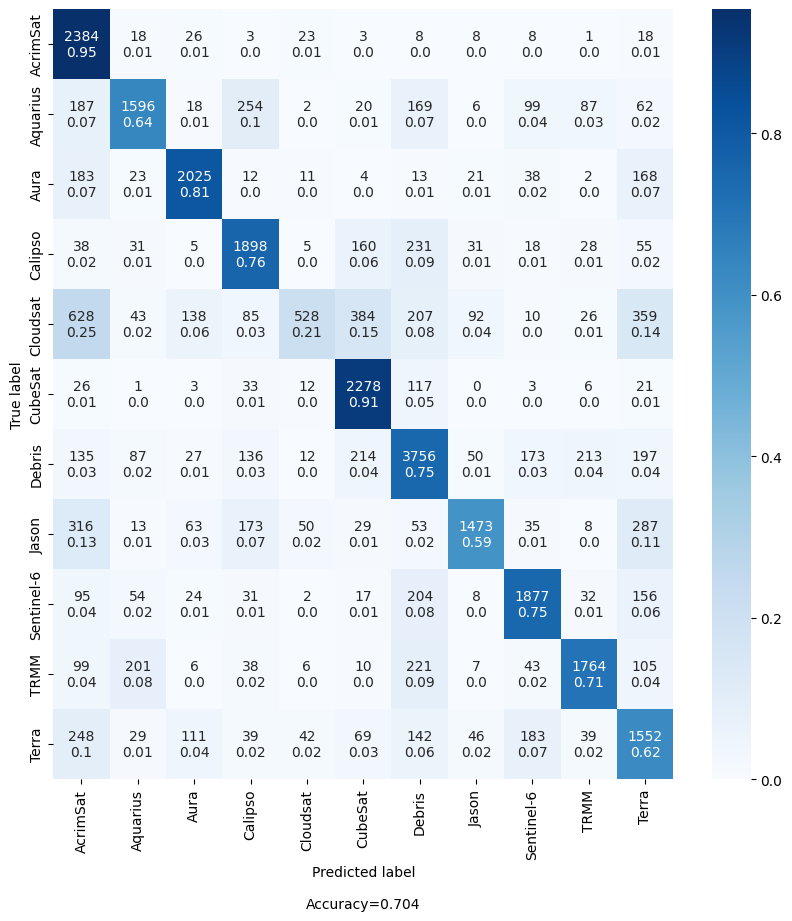

In [14]:
cf_matrix = confusion_matrix(y_true, y_pred)
make_confusion_matrix(cf_matrix, percent = True, count= True, categories=class_labels, figsize = (10,10))

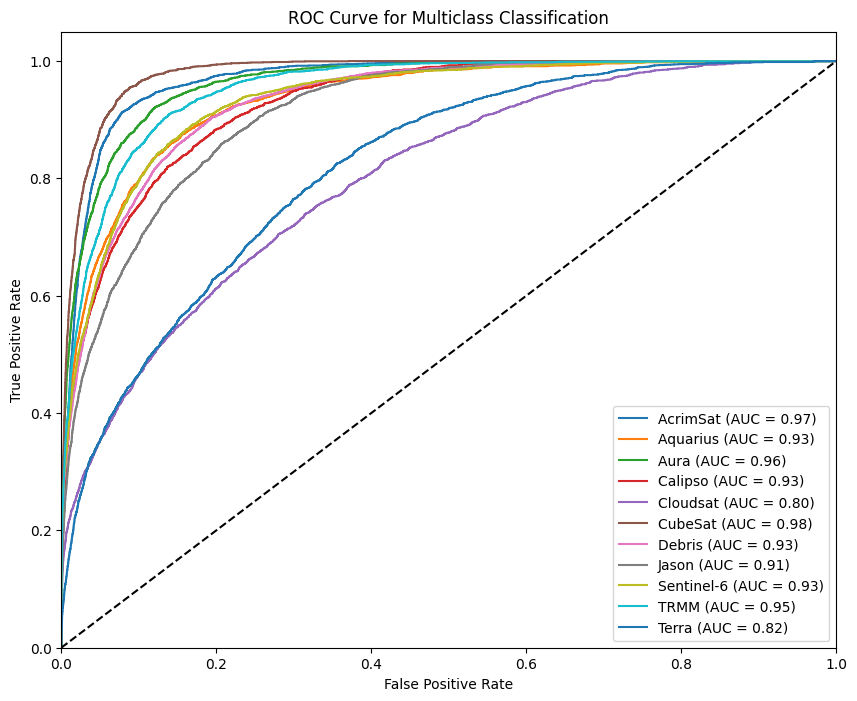

In [18]:
num_classes = 11
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # num_classes should be set to the number of classes in your dataset

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()


In [17]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

    AcrimSat       0.55      0.95      0.70      2500
    Aquarius       0.76      0.64      0.69      2500
        Aura       0.83      0.81      0.82      2500
     Calipso       0.70      0.76      0.73      2500
    Cloudsat       0.76      0.21      0.33      2500
     CubeSat       0.71      0.91      0.80      2500
      Debris       0.73      0.75      0.74      5000
       Jason       0.85      0.59      0.69      2500
  Sentinel-6       0.75      0.75      0.75      2500
        TRMM       0.80      0.71      0.75      2500
       Terra       0.52      0.62      0.57      2500

    accuracy                           0.70     30000
   macro avg       0.72      0.70      0.69     30000
weighted avg       0.73      0.70      0.69     30000

